In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

## Data Exploration and Preprocessing

1. Loading and Exploring the Dataset

In [22]:
df = pd.read_csv('./diamonds.csv')

df.info()
df.describe()
df.head()
df.drop(df.columns[0], axis=1, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  53940 non-null  int64  
 1   carat       53940 non-null  float64
 2   cut         53940 non-null  object 
 3   color       53940 non-null  object 
 4   clarity     53940 non-null  object 
 5   depth       53940 non-null  float64
 6   table       53940 non-null  float64
 7   price       53940 non-null  int64  
 8   x           53940 non-null  float64
 9   y           53940 non-null  float64
 10  z           53940 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB


2. Handling Missing Values

In [23]:
# check if has null values in dataset
print(df.isnull().sum())

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64


3. Categorical to Numerical Conversion

In [24]:
# use one-hot encoding
data_encoded = pd.get_dummies(df, columns=['cut', 'color', 'clarity'], drop_first=True)

4. Target Feature

In [25]:
y = data_encoded['price']

5. Data Visualization

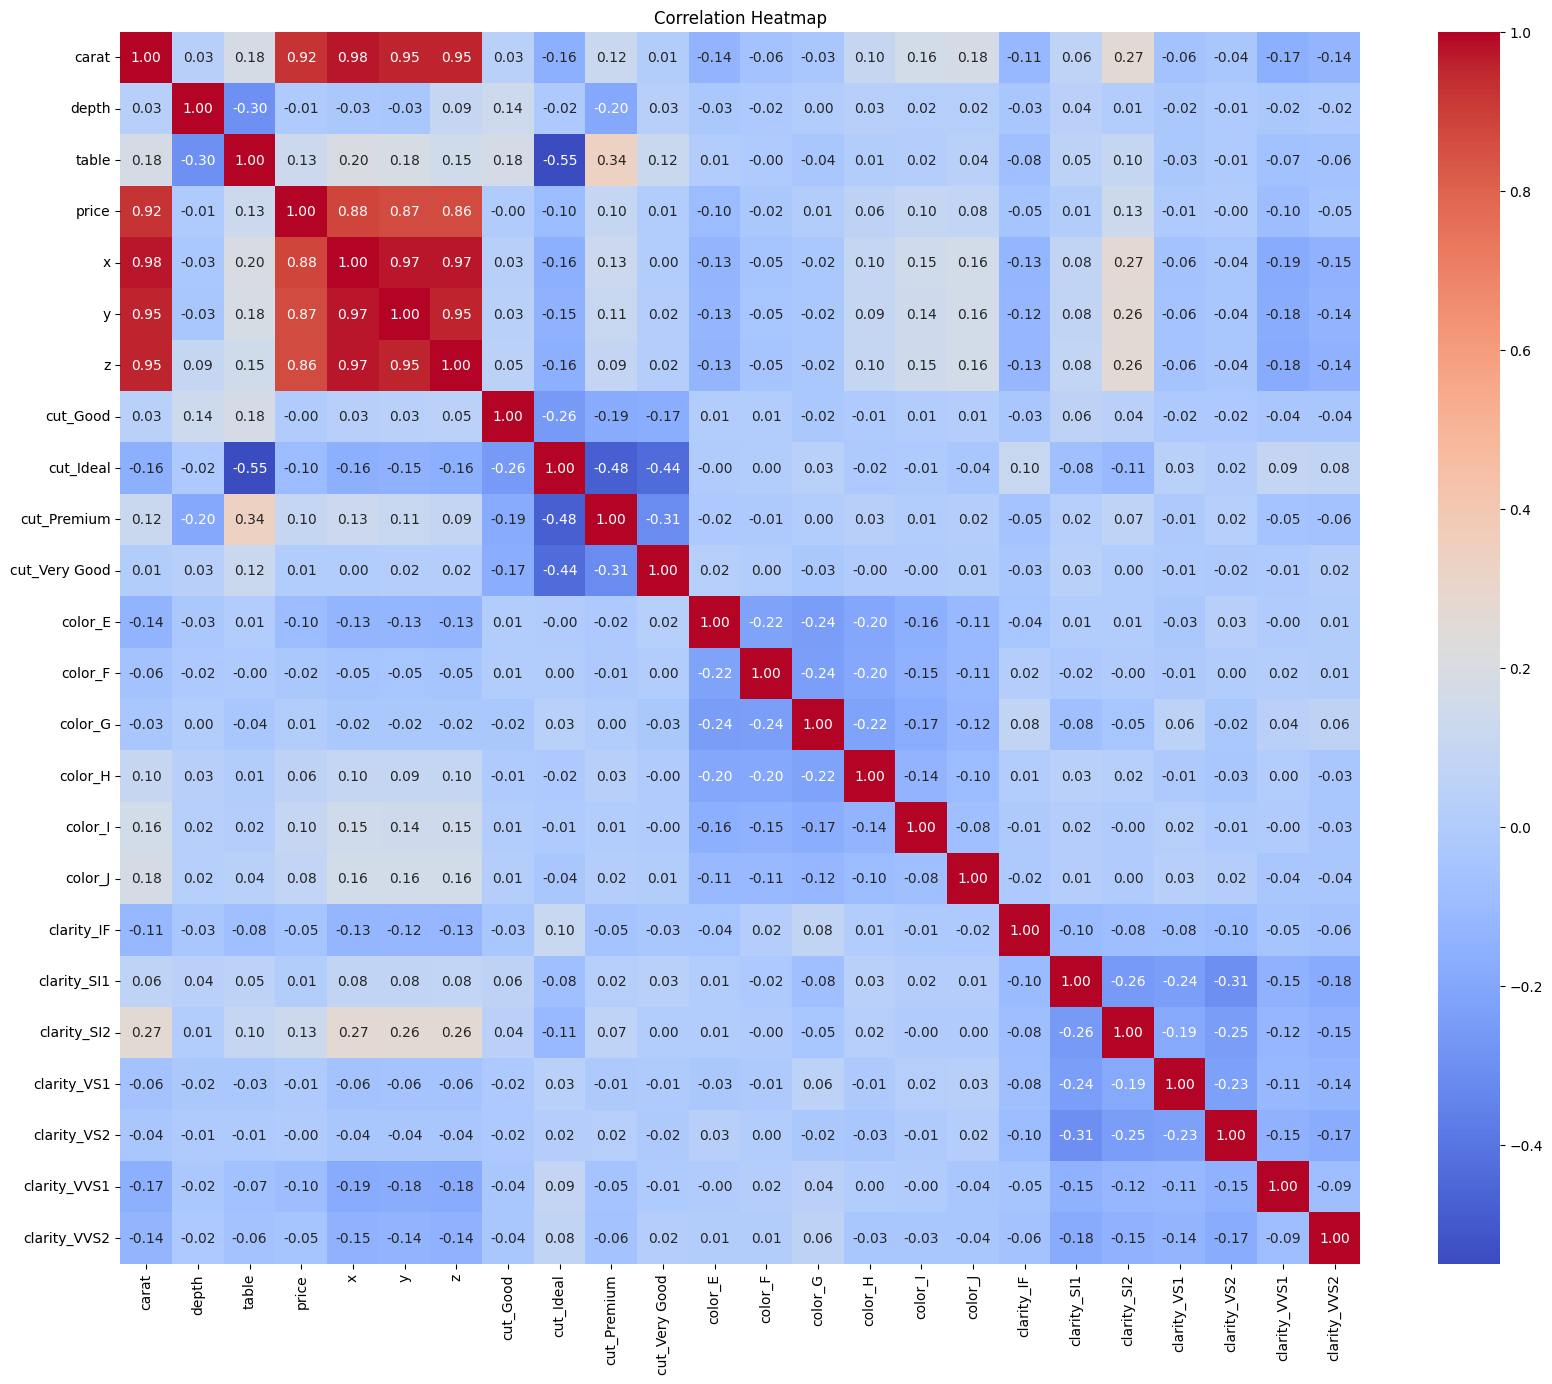

carat            0.921591
x                0.884435
y                0.865421
z                0.861249
clarity_SI2      0.128420
table            0.127134
color_I          0.097125
cut_Premium      0.095706
color_J          0.081710
color_H          0.059223
clarity_SI1      0.008957
color_G          0.008556
cut_Very Good    0.006593
cut_Good        -0.000312
clarity_VS2     -0.001062
clarity_VS1     -0.009886
depth           -0.010647
color_F         -0.024161
clarity_IF      -0.049596
clarity_VVS2    -0.052381
clarity_VVS1    -0.095266
cut_Ideal       -0.097175
color_E         -0.101089
Name: price, dtype: float64


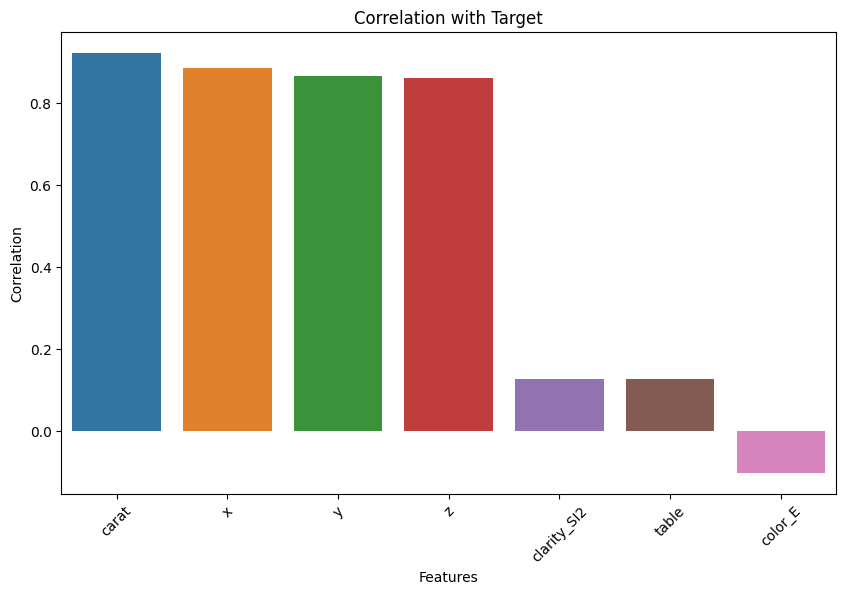

Selected Features:
carat          0.921591
x              0.884435
y              0.865421
z              0.861249
clarity_SI2    0.128420
table          0.127134
color_E       -0.101089
Name: price, dtype: float64


In [26]:
# Calculate correlations
correlations = data_encoded.corr()

# Correlation with the target variable ('price')
correlation_with_target = correlations['price'].sort_values(ascending=False)[1:]

# Plot a heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(correlations, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

# Display correlation of each feature with the target variable
print(correlation_with_target)

correlation_threshold = 0.1
selected_features = correlation_with_target[abs(correlation_with_target) > correlation_threshold]

# Plot correlation values for selected features
plt.figure(figsize=(10, 6))
sns.barplot(x=selected_features.index, y=selected_features)
plt.xticks(rotation=45)
plt.title('Correlation with Target')
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.show()

# List the selected features
print("Selected Features:")
print(selected_features)

6. Data Splitting for Model Training

In [27]:
X = data_encoded[selected_features.index]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Learning Models

1. Linear Regression

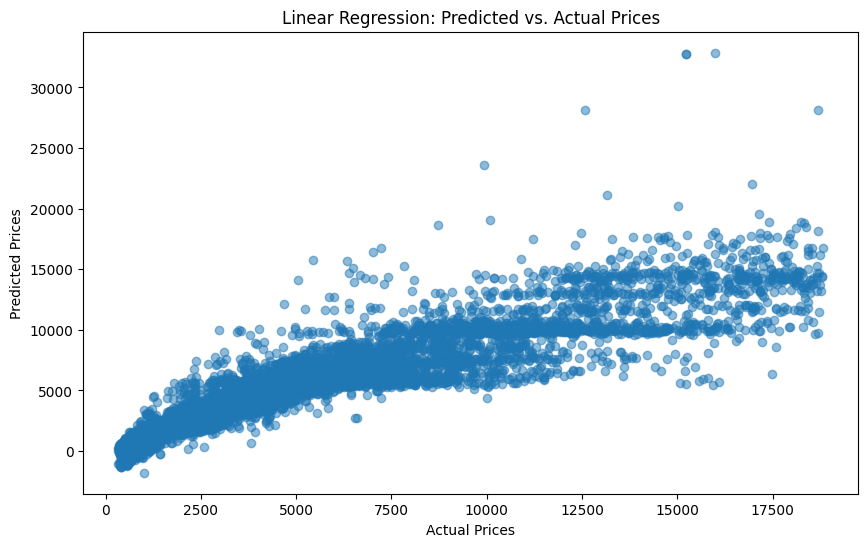

Training Mean Absolute Error: 855.8573846326126
Training R2 Score: 0.8705290397140235
Test Mean Absolute Error: 847.2756995242472
Test R2 Score: 0.8712339868729347


In [28]:
# Initialize and train a Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the training set
train_predictions = model.predict(X_train)

# Calculate mean absolute error and R2 score for the training set
train_mae = mean_absolute_error(y_train, train_predictions)
train_r2 = r2_score(y_train, train_predictions)

# Make predictions on the test set
test_predictions = model.predict(X_test)

# Calculate mean absolute error and R2 score for the test set
test_mae = mean_absolute_error(y_test, test_predictions)
test_r2 = r2_score(y_test, test_predictions)

# Create a plot to visualize predicted prices vs. actual prices in the test set
plt.figure(figsize=(10, 6))
plt.scatter(y_test, test_predictions, alpha=0.5)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Linear Regression: Predicted vs. Actual Prices')
plt.show()

# Print results
print(f"Training Mean Absolute Error: {train_mae}")
print(f"Training R2 Score: {train_r2}")
print(f"Test Mean Absolute Error: {test_mae}")
print(f"Test R2 Score: {test_r2}")

2. Neural Network

Epoch 1/100
1180/1180 [==============================] - 2s 1ms/step - loss: 8836142.0000 - val_loss: 685777.8750
Epoch 2/100
1180/1180 [==============================] - 2s 1ms/step - loss: 870121.0625 - val_loss: 320593.6250
Epoch 3/100
1180/1180 [==============================] - 2s 1ms/step - loss: 643759.9375 - val_loss: 201084.9844
Epoch 4/100
1180/1180 [==============================] - 1s 1ms/step - loss: 537328.5000 - val_loss: 133578.4688
Epoch 5/100
1180/1180 [==============================] - 1s 1ms/step - loss: 484875.1875 - val_loss: 98622.3047
Epoch 6/100
1180/1180 [==============================] - 1s 1ms/step - loss: 441178.8438 - val_loss: 80842.1016
Epoch 7/100
1180/1180 [==============================] - 2s 1ms/step - loss: 411505.8750 - val_loss: 70300.9766
Epoch 8/100
1180/1180 [==============================] - 2s 1ms/step - loss: 404588.8125 - val_loss: 72266.3516
Epoch 9/100
1180/1180 [==============================] - 1s 1ms/step - loss: 362767.8125 - val_loss

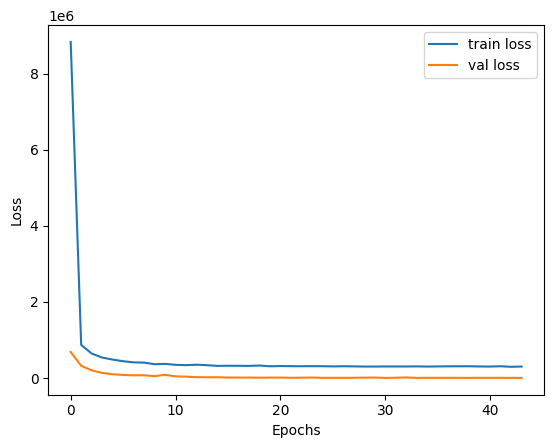

253/253 [==============================] - 0s 667us/step
Training Mean Absolute Error: 257.09293942277804
Training R2 Score: 0.9858568703909388
Test Mean Absolute Error: 34.72952232789881
Test R2 Score: 0.9998720928823905


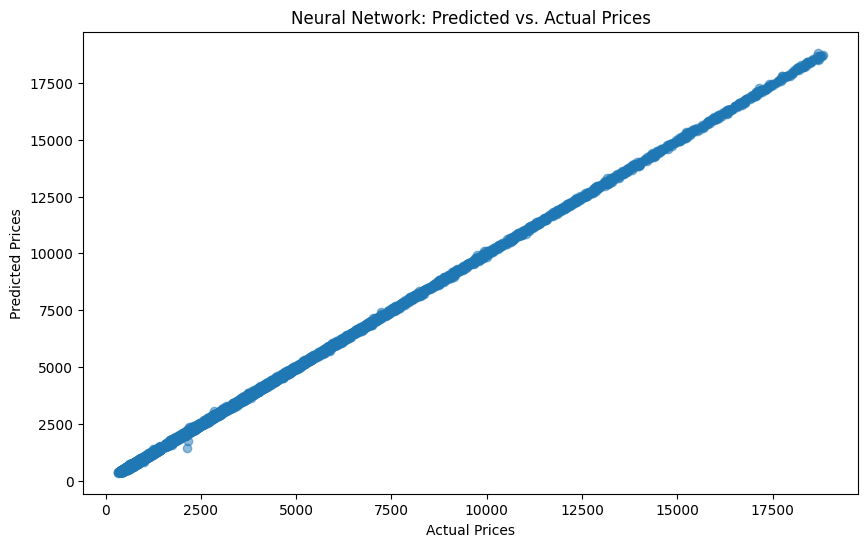

In [31]:
# data split
X = data_encoded.drop(columns=['price'])
X_train, X_temp, y_train, y_temp = train_test_split(data_encoded, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=100, batch_size=32, callbacks=[early_stopping])

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Make predictions on the test set
test_predictions = model.predict(X_test_scaled)

# Calculate mean absolute error and R2 score for the test set
test_mae = mean_absolute_error(y_test, test_predictions)
test_r2 = r2_score(y_test, test_predictions)

print(f"Training Mean Absolute Error: {train_mae}")
print(f"Training R2 Score: {train_r2}")
print(f"Test Mean Absolute Error: {test_mae}")
print(f"Test R2 Score: {test_r2}")

# Visualize predicted prices vs. actual prices in the test set
plt.figure(figsize=(10, 6))
plt.scatter(y_test, test_predictions, alpha=0.5)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Neural Network: Predicted vs. Actual Prices')
plt.show()

3. Random Forest

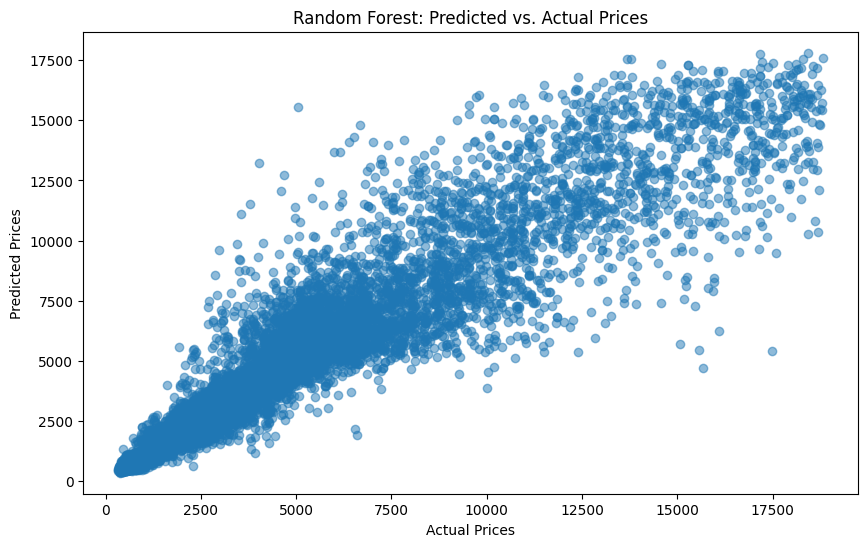

Training Mean Absolute Error: 257.09293942277804
Training R2 Score: 0.9858568703909388
Test Mean Absolute Error: 677.2326137961264
Test R2 Score: 0.9000097051393313


In [30]:
# Data split
X = data_encoded[selected_features.index]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Initialize and train a Random Forest Regressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the training set
train_predictions = model.predict(X_train)

# Calculate mean absolute error and R2 score for the training set
train_mae = mean_absolute_error(y_train, train_predictions)
train_r2 = r2_score(y_train, train_predictions)

# Make predictions on the test set
test_predictions = model.predict(X_test)

# Calculate mean absolute error and R2 score for the test set
test_mae = mean_absolute_error(y_test, test_predictions)
test_r2 = r2_score(y_test, test_predictions)

# Create a plot to visualize predicted prices vs. actual prices in the test set
plt.figure(figsize=(10, 6))
plt.scatter(y_test, test_predictions, alpha=0.5)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Random Forest: Predicted vs. Actual Prices')
plt.show()

# Print results
print(f"Training Mean Absolute Error: {train_mae}")
print(f"Training R2 Score: {train_r2}")
print(f"Test Mean Absolute Error: {test_mae}")
print(f"Test R2 Score: {test_r2}")

## Parameter Tuning